# DR candidate assignment - Interaktiv notebook version
Følgende er en step-by-step løsning af Candidate assignment i en Jupyter Notebook.
For at spare din tid har jeg uploadet en HTML-version du nemt kan åbne i browseren. Så behøver du ikke installere Jupyter, for at køre det.

In [1]:
import requests

import UserSchema
import config

from google.cloud import bigquery
from google.oauth2 import service_account

### Authentication

In [3]:
def authenticate_bigquery_client_with_keyfile(path_to_keyfile, location=None) -> bigquery.Client:
    credentials = service_account.Credentials.from_service_account_file(path_to_keyfile)
    # insert Error handling here
    return bigquery.Client(credentials=credentials, project=credentials.project_id, location=location)

key_path = "INSERT_PATH_TO_KEYFILE_HERE"

client = authenticate_bigquery_client_with_keyfile(key_path, location=config.location)

Access variabler ligger i en separat fil kaldet "config.py"
Her bliver config.location brugt til at sætte location til "europe-west1" 

### Checks og oprettelse af table
Her tjekker vi om datasettet "candidate_assignment" eksisterer i vores projekt playground, og om tabellen vi skal oprette allerede eksisterer.

I opgaven er det måske overflødigt, men det er blot for at fremvise opmærksomhed på at checks kan være relevante i virkeligheden.

In [4]:
def dataset_in_project(client, dataset_id):
    datasets = list(client.list_datasets())
    return dataset_id in [dataset.dataset_id for dataset in datasets]

if not dataset_in_project(client, config.dataset_id):
        print("Error: dataset could not be found in project")
        

table_list = list(client.list_tables(dataset=config.dataset_id))
table_name_list = [table.table_id for table in table_list]
print(f"Existing tables: {table_name_list}")
table_id = f"{config.project_id}.{config.dataset_id}.{config.table_name}"

if config.table_name in table_name_list:
    print(f"Table {config.table_name} already exists")
else:
    print(f"Creating table {table_name}")
    table = bigquery.Table(table_id, schema=UserSchema.schema)
    table_id = client.create_table(table)


Existing tables: ['behlul_users', 'jesper_users']
Table behlul_users already exists


### Table Schema
Schema for den nye table er defineret i en separat fil kaldet "UserSchema.py"

In [ ]:
schema = [
    bigquery.SchemaField("id", "INT64", mode="REQUIRED"),
    bigquery.SchemaField("name", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("username", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("email", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("address", "RECORD", mode="REQUIRED",
                         fields=[
                             bigquery.SchemaField("street", "STRING", mode="REQUIRED"),
                             bigquery.SchemaField("suite", "STRING", mode="REQUIRED"),
                             bigquery.SchemaField("city", "STRING", mode="REQUIRED"),
                             bigquery.SchemaField("zipcode", "STRING", mode="REQUIRED"),
                             bigquery.SchemaField("geo", "RECORD", mode="REQUIRED",
                                                  fields=[
                                                      bigquery.SchemaField("lat", "STRING", mode="REQUIRED"),
                                                      bigquery.SchemaField("lng", "STRING", mode="REQUIRED"),
                                                  ])
                         ]),
    bigquery.SchemaField("phone", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("website", "STRING", mode="NULLABLE"),  # Allow for users with no website
    bigquery.SchemaField("company", "RECORD", mode="NULLABLE",  # Allow for users with no company
                         fields=[
                             bigquery.SchemaField("name", "STRING", mode="REQUIRED"),
                             bigquery.SchemaField("catchPhrase", "STRING", mode="NULLABLE"),
                             bigquery.SchemaField("bs", "STRING", mode="NULLABLE")
                         ])
]

Bemærk at "id" feltet er af type "INT64" af følgende grund:

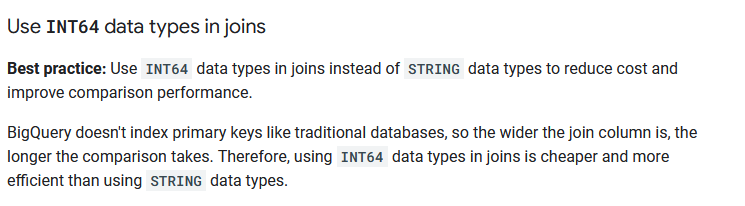

Source: https://cloud.google.com/bigquery/docs/best-practices-performance-compute#use_int64_data_types_in_joins

---

Da jeg skrev schema'et for tabellen har jeg gjort nogle antagelser.
I rigtige arbejdsomstændigher vil jeg istedet undersøge kravene og drøfte med leder.

- website og company er sat til at være NULLABLE, under den antagelse at ikke alle (fremtidige) users har en website eller er tilknyttet en virksomhed
- Det ovenstående gælder også for catchPhrase og bs inde under company

Man kan også løse opgaven ved at lave en ny tabel for companies for at undgå duplikeret data, når samtlige users har samme company.

### JSON
Vi henter JSON ned med følgende metode, som optionelt kan angives en limit.

In [5]:
def fetch_json(url, limit=None):
    response = requests.get(url)
    JSON = response.json()[:limit]
    return JSON

users = fetch_json(config.user_json_source_url, limit=10)

### Indsæt JSON i BigQuery table

In [6]:
errors = client.insert_rows_json(table_id, users)
if errors:
    print(f"Encountered errors while inserting rows: {errors}")
else:
    print("New rows have been added")

New rows have been added


## Estimat på omkostninger for en query i et BigQuery dataset

In [7]:
job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
query_job = client.query(
    (
        "SELECT "
        "*"
        "FROM"
        "`bigquery-public-data.github_repos.commits`"
    ),
    job_config=job_config,
    location="US"
)
print(f"This query will process {query_job.total_bytes_processed} bytes")
print(f"This query will be billed for {query_job.total_bytes_billed} bytes")
print("The query will be billed for 0 DKK according to Google Cloud Pricing Calculator:")
print("https://cloud.google.com/products/calculator?hl=da&dl=CiRkNmE5NzEwZi03ZDhiLTRmNzctOTVjNS03YjViYmMzM2EzOGQQCxokMTEwRjQwQzMtMTQwMC00RTYxLUJGMDYtREYzQzQ2NERDRkZC")

This query will process 910555228896 bytes
This query will be billed for 0 bytes
The query will be billed for 0 DKK according to Google Cloud Pricing Calculator:
https://cloud.google.com/products/calculator?hl=da&dl=CiRkNmE5NzEwZi03ZDhiLTRmNzctOTVjNS03YjViYmMzM2EzOGQQCxokMTEwRjQwQzMtMTQwMC00RTYxLUJGMDYtREYzQzQ2NERDRkZC


At køre den givne query ville processere over 900 GB data, men ville være omkostningsfrit da man ikke ville blive faktureret for de bytes der hentes.
Det kan man også komme frem til via Googles Cost calculator, som linket fører til. 